# **Data Analytics - Programming Assignment 1**

**Name:** Justin Alec M. Antonio <br>
**Course & Year:** BSCS - 2
<hr>

### **List of Procedures**
1. Data Collection
2. Risk Set Matching
3. Data Analysis and Comparisons
4. Balanced Pair Matching
5. Results and Graphing


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import mahalanobis
import networkx as nx
from pulp import LpMinimize, LpProblem, LpVariable, lpSum

In [46]:
# 1. Data Collection
baseline = pd.read_csv('dataset1.csv')
evaluations = pd.read_csv('dataset2.csv')

# Cleaning
evaluations['time_treated'] = evaluations['time_treated'].fillna(0).astype(int)
treated_patients = evaluations[evaluations['treated'] == True][['patient_id', 'time_treated']].drop_duplicates(subset='patient_id')


In [51]:
# 2. Risk Set Matching

# Merge evaluations with baseline data on patient_id
combined = evaluations.merge(baseline, on='patient_id', how='left')

# For treated patients, keep records just before treatment time
treated_combined = combined[combined['treated'] == True].copy()
treated_combined = treated_combined[treated_combined['time_since_entry'] <= treated_combined['time_treated']]

# For untreated controls, keep the latest record
controls_combined = combined[combined['treated'] == False].copy()
controls_combined = controls_combined.sort_values('time_since_entry').groupby('patient_id').last().reset_index()

# Combine both for covariance calculation
cov_data = pd.concat([treated_combined, controls_combined])

# Select relevant variables
symptoms = cov_data[['pain_b', 'urgency_b', 'frequency_b', 'pain', 'urgency', 'frequency']].dropna()

# Compute covariance matrix and its inverse
cov_matrix = symptoms.cov()
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Function to calculate Mahalanobis distance
def calculate_mahalanobis(treated_row, control_row):
    x = treated_row[['pain_b', 'urgency_b', 'frequency_b', 'pain', 'urgency', 'frequency']].values
    y = control_row[['pain_b', 'urgency_b', 'frequency_b', 'pain', 'urgency', 'frequency']].values
    return mahalanobis(x, y, inv_cov_matrix)

# Get treated and never treated patients
treated_patients = combined[combined['treated'] == True][['patient_id', 'time_treated']].drop_duplicates(subset='patient_id')
never_treated = combined[~combined['patient_id'].isin(treated_patients['patient_id'])][['patient_id', 'time_treated']].drop_duplicates(subset='patient_id')
all_patients = pd.concat([treated_patients, never_treated])

# Create risk set
risk_set = []
for _, row in treated_patients.iterrows():
    treatment_time = row['time_treated']
    potential_controls = all_patients[(all_patients['time_treated'] == 0) | (all_patients['time_treated'] > treatment_time)]

    # Add symptom data for distance calculation
    treated_symptoms = combined[(combined['patient_id'] == row['patient_id'])].iloc[0]
    control_data = combined[combined['patient_id'].isin(potential_controls['patient_id'])].sort_values('time_since_entry').groupby('patient_id').last().reset_index()

    # Calculate Mahalanobis distance for each control
    controls_with_distance = []
    for _, control_row in control_data.iterrows():
        dist = calculate_mahalanobis(treated_symptoms, control_row)
        controls_with_distance.append((control_row['patient_id'], dist))
    
    risk_set.append({
        'treated_id': row['patient_id'],
        'treatment_time': treatment_time,
        'controls': controls_with_distance,
    })

In [57]:
# 3. Data Analysis and Comparisons

# Construct the Matching Network
G = nx.Graph()  # Changed from DiGraph to Graph

# Add nodes for treated patients and controls
for entry in risk_set:
    treated_id = entry['treated_id']
    G.add_node(f"T_{treated_id}", bipartite=0)  # Treated node

    for control_id, dist in entry['controls']:
        G.add_node(f"C_{control_id}", bipartite=1)  # Control node
        G.add_edge(f"T_{treated_id}", f"C_{control_id}", weight=dist)  # Edge with Mahalanobis distance

# Apply Minimum Cost Matching Algorithm
treated_nodes = [n for n in G.nodes if n.startswith('T_')]
control_nodes = [n for n in G.nodes if n.startswith('C_')]

# Perform Minimum Cost Matching
matching = nx.algorithms.matching.min_weight_matching(G, weight='weight')

# Display the matched pairs
matching_list = list(matching)

print(f"\n🔹 Optimal Matching Results (Matches: {len(matching)})")
print("="*60)
print(f"{'Treated ID':<15}{'Control ID':<15}{'Mahalanobis Distance':<20}")
print("="*60)
for pair in matching_list[:10]:
    treated, control = sorted(pair, reverse=True)  # Ensure treated comes first
    weight = G[treated][control]['weight']
    print(f"{treated:<15}{control:<15}{weight:<20.2f}")
print("="*60)


🔹 Optimal Matching Results (Matches: 180)
Treated ID     Control ID     Mahalanobis Distance
T_144          C_46           1.54                
T_119          C_94           2.21                
T_62           C_60           2.10                
T_74           C_32           0.86                
T_18           C_40           1.74                
T_196          C_77           1.52                
T_185          C_42           2.92                
T_115          C_135          2.08                
T_1            C_48           0.98                
T_180          C_163          1.60                


In [56]:
# 4. Balanced Pair Matching

# Convert Matching Results into a DataFrame
matched_pairs = []
for t_node, c_node in matching:
    treated_id = int(t_node.split("_")[1])
    control_id = int(c_node.split("_")[1])
    weight = G[t_node][c_node]['weight']
    matched_pairs.append({'treated_id': treated_id, 'control_id': control_id, 'distance': weight})

matched_df = pd.DataFrame(matched_pairs)
matched_df.head()

def create_binary_covariates(df, columns, quantiles=[0.33, 0.67]):
    """ Converts continuous variables into binary indicators based on quantiles. """
    for col in columns:
        q_low, q_high = df[col].quantile(quantiles).values  # Get quantile thresholds
        
        df[f"{col}_low"] = (df[col] <= q_low).astype(int)  # Low category
        df[f"{col}_mid"] = ((df[col] > q_low) & (df[col] <= q_high)).astype(int)  # Mid category
        df[f"{col}_high"] = (df[col] > q_high).astype(int)  # High category
        
    return df

# Define symptom columns and create binary covariates
symptom_cols = ['pain', 'urgency', 'frequency', 'pain_b', 'urgency_b', 'frequency_b']
combined = create_binary_covariates(combined, symptom_cols)
binary_symptoms = [f"{col}_{level}" for col in symptom_cols for level in ["low", "mid", "high"]]

# Compute covariance matrix and its inverse for binary symptoms
cov_data = combined[binary_symptoms].dropna()
cov_matrix = cov_data.cov()
inv_cov_matrix = np.linalg.inv(cov_matrix)

def calculate_mahalanobis_binary(row_t, row_c):
    """ Calculate Mahalanobis distance for binary covariates. """
    x = row_t[binary_symptoms].values
    y = row_c[binary_symptoms].values
    return mahalanobis(x, y, inv_cov_matrix)

# Calculate Mahalanobis distances for matched pairs
mah_distances = {}
for _, row in matched_df.iterrows():
    treated_symptoms = combined[combined['patient_id'] == row['treated_id']].iloc[0]
    control_symptoms = combined[combined['patient_id'] == row['control_id']].iloc[0]
    mah_distances[(row['treated_id'], row['control_id'])] = calculate_mahalanobis_binary(treated_symptoms, control_symptoms)
    
# Define Integer Programming Model
model = LpProblem("Balanced_Risk_Set_Matching", LpMinimize)

# Define decision variables
f = LpVariable.dicts("Match", mah_distances.keys(), cat="Binary")  # Matching variables
g_plus = LpVariable.dicts("G_Plus", range(3), lowBound=0, cat="Continuous")  # Balance gaps
g_minus = LpVariable.dicts("G_Minus", range(3), lowBound=0, cat="Continuous")  # Balance gaps

# Objective Function: Minimize Mahalanobis distance + penalty for imbalance
lambda_k = 1000  # Large penalty for imbalance
model += lpSum(f[e] * mah_distances[e] for e in mah_distances) + lambda_k * lpSum(g_plus[k] + g_minus[k] for k in range(3))

# Constraints

# Each treated patient is matched exactly once
for t in matched_df['treated_id']:
    model += lpSum(f[(t, c)] for c in matched_df['control_id'] if (t, c) in f) == 1

# Each control patient is matched at most once
for c in matched_df['control_id']:
    model += lpSum(f[(t, c)] for t in matched_df['treated_id'] if (t, c) in f) <= 1

# Balance Constraints (Simulated binary covariate sums)
treated_binary_sums = [3, 2, 4]  # Example binary totals for three covariates
control_binary_sums = {k: lpSum(f[e] for e in mah_distances) for k in range(3)}

for k in range(3):  # Balance for each covariate
    model += treated_binary_sums[k] - control_binary_sums[k] <= g_plus[k]
    model += control_binary_sums[k] - treated_binary_sums[k] <= g_minus[k]

# Solve the model
model.solve()

# Extract final matched pairs
final_matched_pairs = [(t, c) for (t, c) in mah_distances.keys() if f[(t, c)].varValue == 1]

# Display Results
print(f"\n🔹 Final Balanced Matching Results (Pairs: {len(final_matched_pairs)})")
print("="*50)
print(f"{'Treated ID':<15}{'Control ID':<15}{'Mahalanobis Distance':<20}")
print("="*50)
for t, c in final_matched_pairs[:10]:
    print(f"{t:<15}{c:<15}{mah_distances[(t, c)]:<20.2f}")
print("="*50)


🔹 Final Balanced Matching Results (Pairs: 102)
Treated ID     Control ID     Mahalanobis Distance
74.0           32.0           5.60                
18.0           40.0           4.50                
42.0           185.0          4.38                
1.0            48.0           4.42                
180.0          163.0          4.53                
50.0           46.0           6.11                
73.0           106.0          5.06                
107.0          128.0          3.55                
165.0          24.0           4.39                
122.0          175.0          3.40                


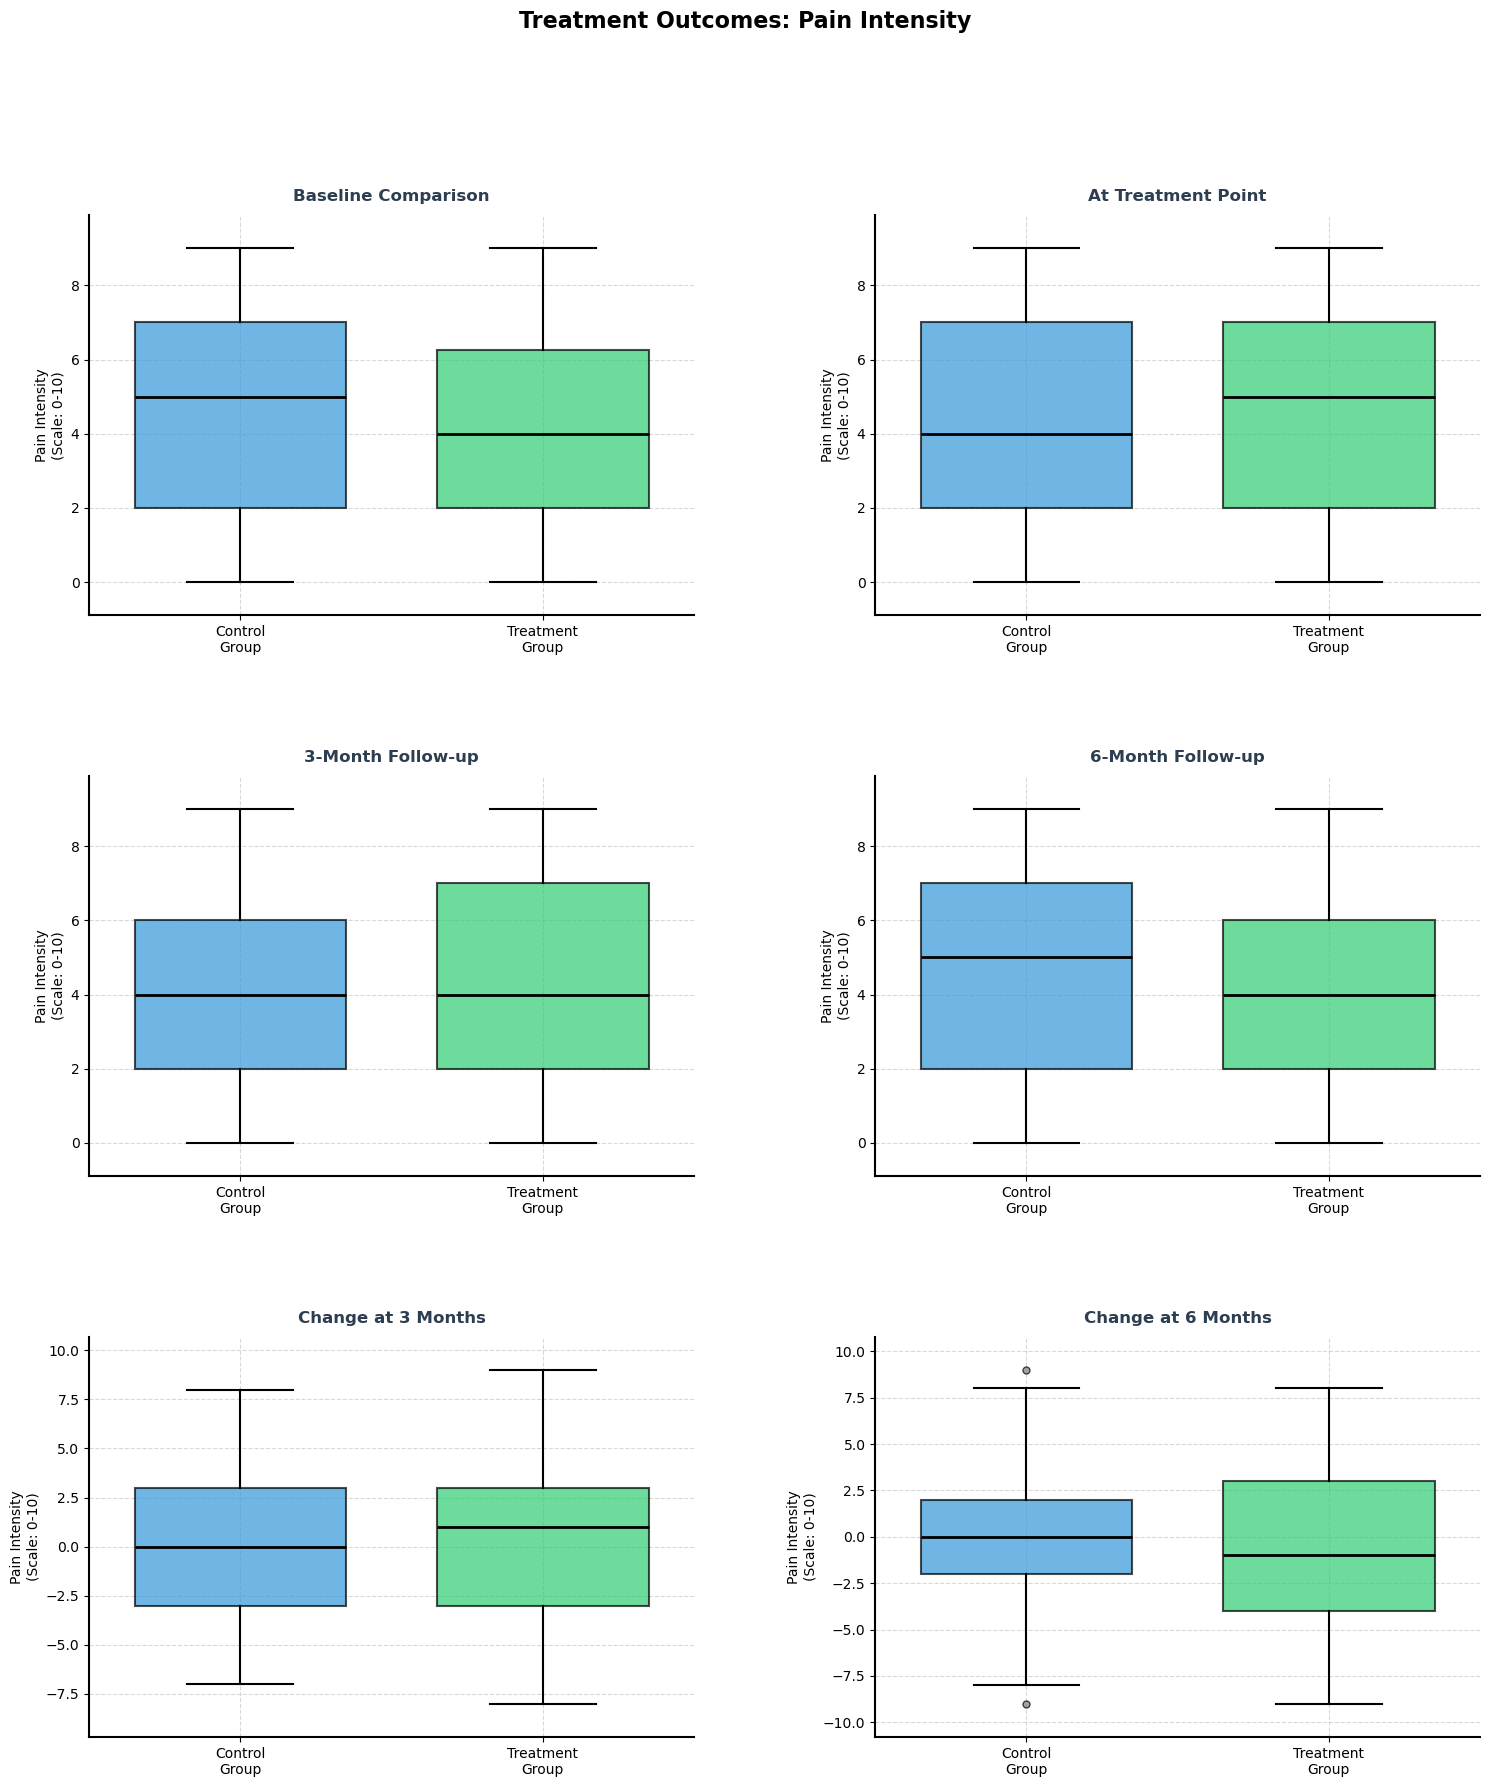

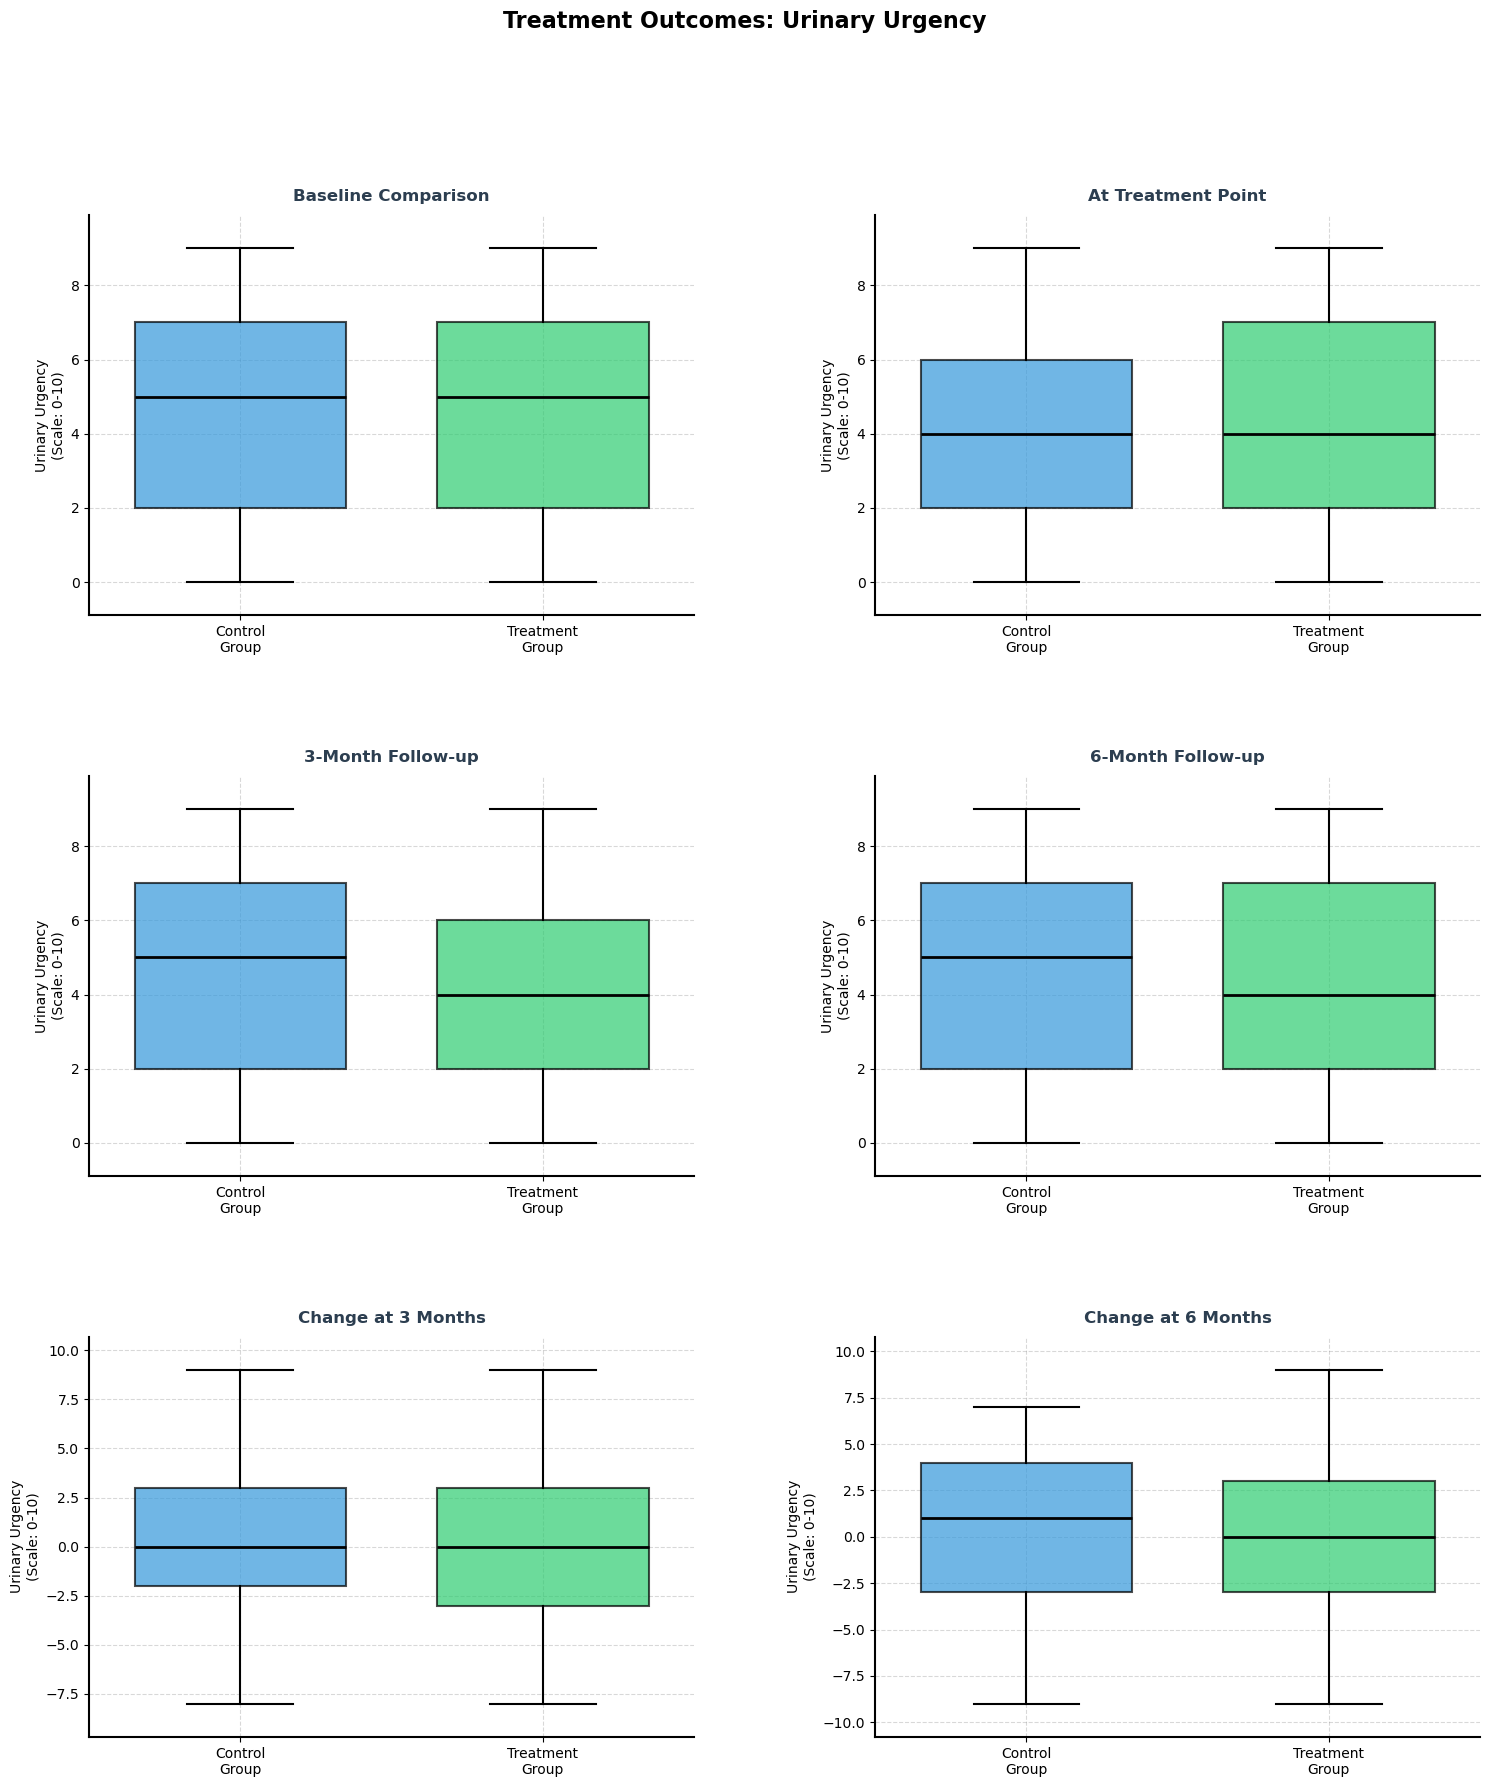

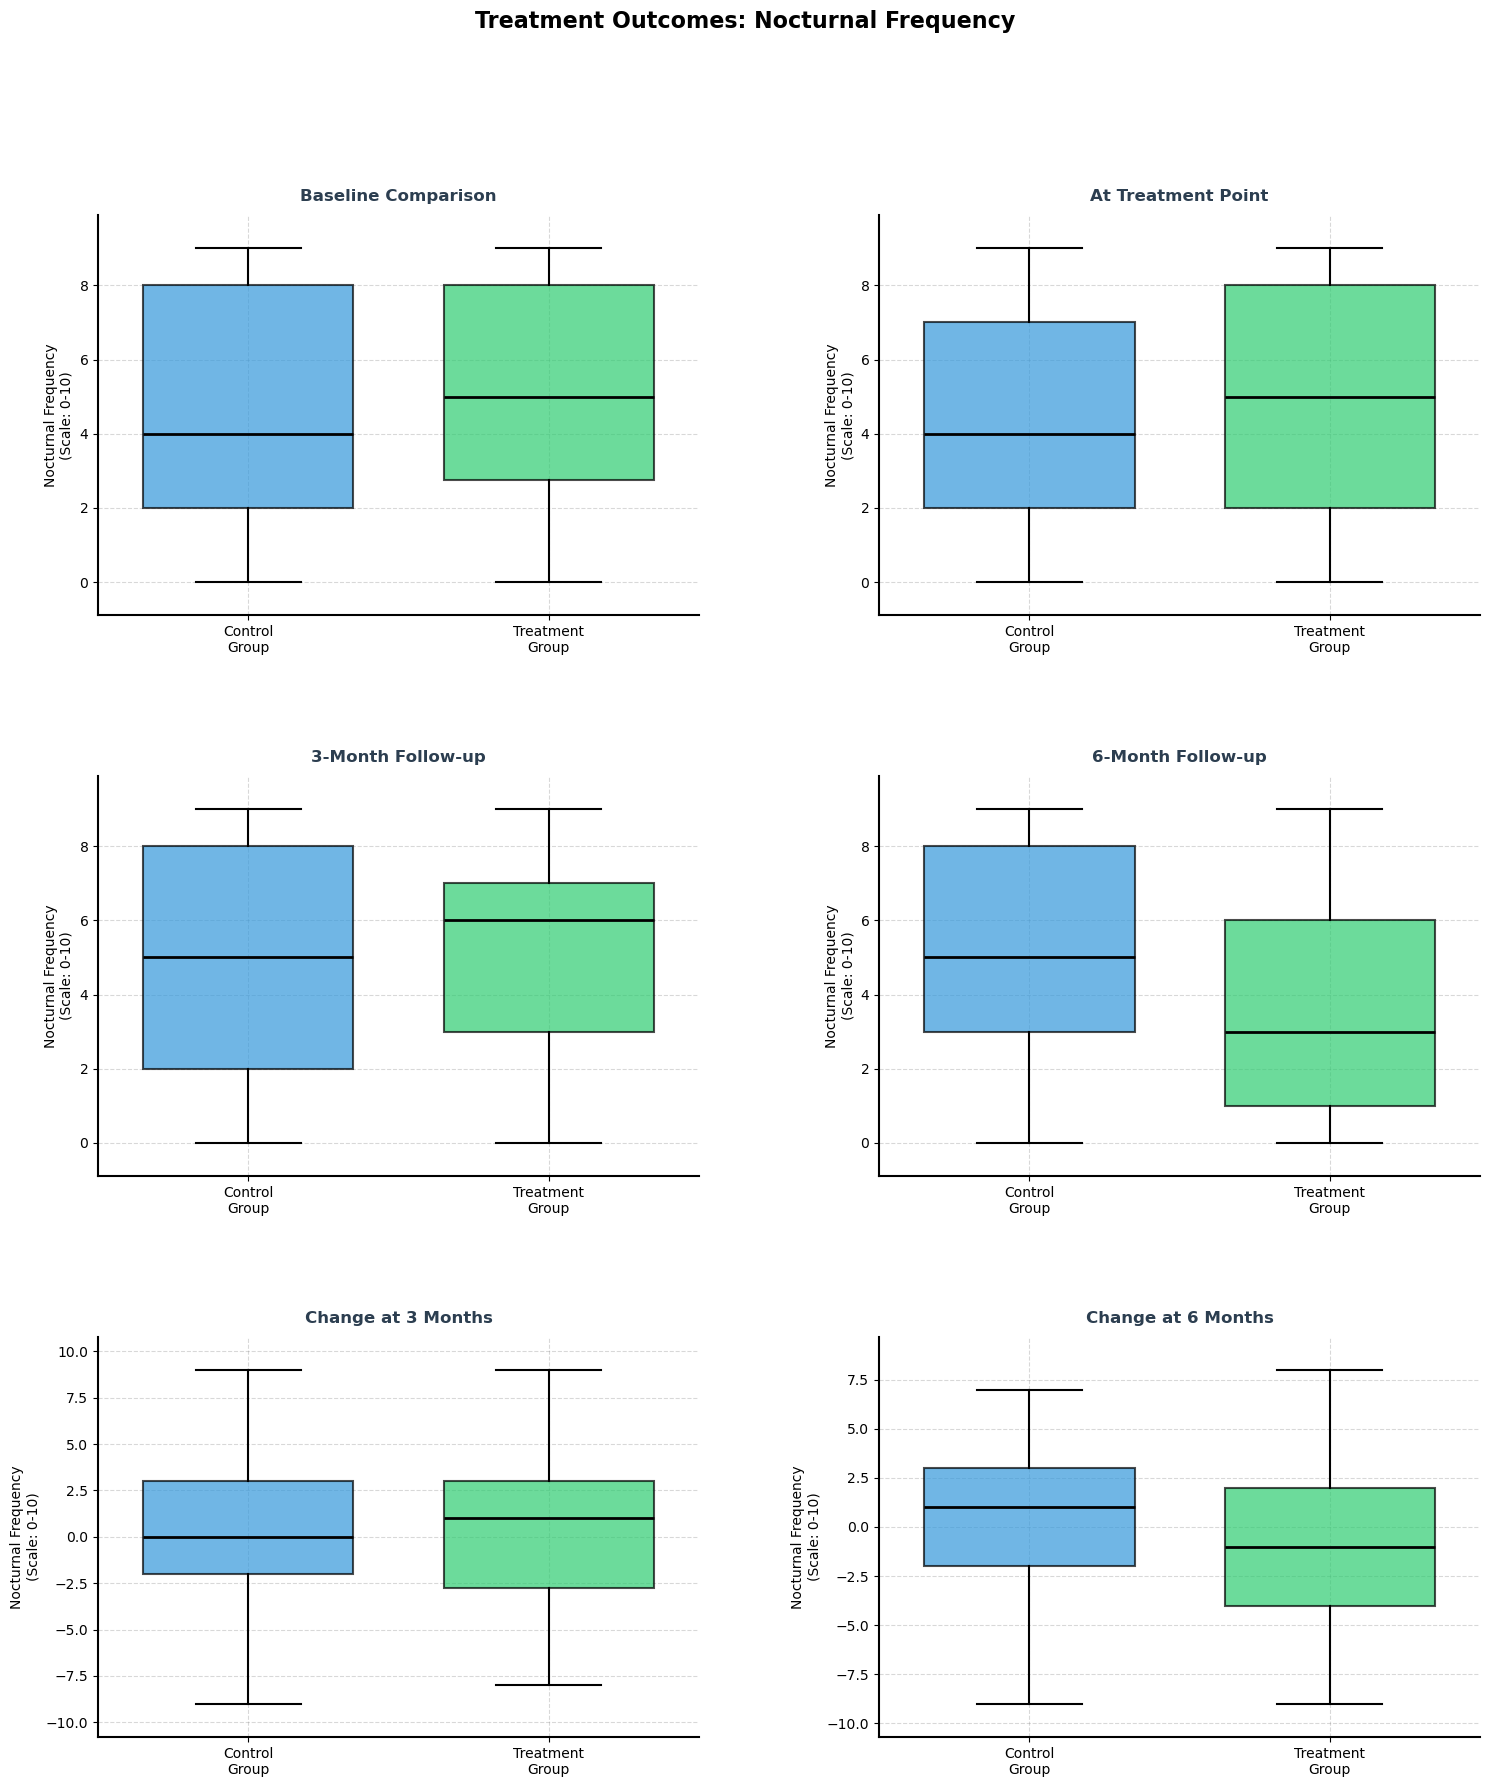

In [61]:
def display_boxplots(column, title):
    """
    Display enhanced boxplots comparing treatment outcomes
    """
    global dataframes
    
    # Set style for better visualization
    plt.style.use('default')
    
    # Create figure and subplots with adjusted size
    num_rows = len(dataframes) // 4
    fig, axes = plt.subplots(num_rows, 2, figsize=(15, 6 * num_rows), dpi=100)
    fig.suptitle(f'Treatment Outcomes: {title}', fontsize=16, y=1.02, fontweight='bold')
    
    # Flatten axes for easier indexing
    axes = axes.flatten()

    # Define better titles and colors
    box_titles = [
        'Baseline Comparison',
        'At Treatment Point',
        '3-Month Follow-up',
        '6-Month Follow-up',
        'Change at 3 Months',
        'Change at 6 Months'
    ]
    
    # Enhanced color scheme
    colors = ['#3498db', '#2ecc71']  # Blue and Green
    
    # Iterate through each pair of dataframes
    for i in range(0, len(dataframes), 2):    
        if dataframes[i].empty or dataframes[i+1].empty:
            continue
        
        # Create enhanced boxplot with more styling
        bp = axes[i // 2].boxplot([dataframes[i][column].dropna(), 
                                 dataframes[i + 1][column].dropna()],
                                patch_artist=True,
                                widths=0.7,
                                medianprops=dict(color="black", linewidth=2),
                                flierprops=dict(marker='o', markerfacecolor='gray', 
                                              markersize=5, alpha=0.7),
                                whiskerprops=dict(linewidth=1.5),
                                capprops=dict(linewidth=1.5))
        
        # Enhanced box coloring
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
            patch.set_linewidth(1.5)
        
        # Customize the plot with enhanced styling
        axes[i // 2].set_title(box_titles[i // 2], pad=10, fontsize=12, 
                             fontweight='bold', color='#2c3e50')
        axes[i // 2].set_ylabel(f'{title}\n(Scale: 0-10)', fontsize=10)
        axes[i // 2].grid(True, linestyle='--', alpha=0.3, color='gray')
        axes[i // 2].set_xticklabels(['Control\nGroup', 'Treatment\nGroup'], 
                                   fontsize=10, rotation=0)
        
        # Set y-axis limits with some padding
        y_min = min(dataframes[i][column].min(), dataframes[i+1][column].min())
        y_max = max(dataframes[i][column].max(), dataframes[i+1][column].max())
        padding = (y_max - y_min) * 0.1
        axes[i // 2].set_ylim(y_min - padding, y_max + padding)
        
        # Remove top and right spines
        axes[i // 2].spines['top'].set_visible(False)
        axes[i // 2].spines['right'].set_visible(False)
        axes[i // 2].spines['left'].set_linewidth(1.5)
        axes[i // 2].spines['bottom'].set_linewidth(1.5)

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.subplots_adjust(wspace=0.3, hspace=0.4)

    # Show plot
    plt.show()

# Display enhanced boxplots for each symptom
display_boxplots('pain', 'Pain Intensity')
display_boxplots('urgency', 'Urinary Urgency')
display_boxplots('frequency', 'Nocturnal Frequency')